# Introduction

In this notebook I will examine the effect of regularization techniques on the output.

1. [Dataset](#1)
    1. [Preparation](#1.1)
        1. [Normalization](#1.1.1)
        1. [Reshaping](#1.1.2)
        1. [Train - validation split](#1.1.3)
1. [Core architecture](#2)
1. [Regularization techniques](#3)
    1. [Dropout](#3.1)
        1. [Architecture 1](#3.1.1)
        1. [Architecture 2](#3.1.2)
        1. [Architecture 3](#3.1.3)
        1. [Results](#3.1.4)
    1. [Batch normalization](#3.2)
        1. [Architecture 1](#3.2.1)
        1. [Batch normalization + dropout](#3.2.2)
    1. [Layer normalization](#3.3)
    1. [Lasso, ridge and elastic regularization](#3.4)
        1. [L2 regularization](#3.4.1)
        1. [L1 regularization](#3.4.2)
        1. [Elastic regularization](#3.4.3)
    1. [Data augmentation](#3.5)
1. [Final architecture](#4)

# Dataset <a id=1></a>

Lets quickly check the dataset first.

This dataset is well-known and well-studied dataset and 101 of the computer vision. For more information, please check the 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))        

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
print(df_train.info()) # 42000 entries, 784 pixels on each image, and 1 label

print("-"*40)

print(df_test.info()) # 28000 entries, 784 pixels, no label for obvious reasons

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


In [4]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train["label"].values
X_test = df_test.values

In [6]:
print(type(X_train), X_train.shape)

print(type(y_train), y_train.shape)

print(type(X_test), X_test.shape)

<class 'numpy.ndarray'> (42000, 784)
<class 'numpy.ndarray'> (42000,)
<class 'numpy.ndarray'> (28000, 784)


lets check one image

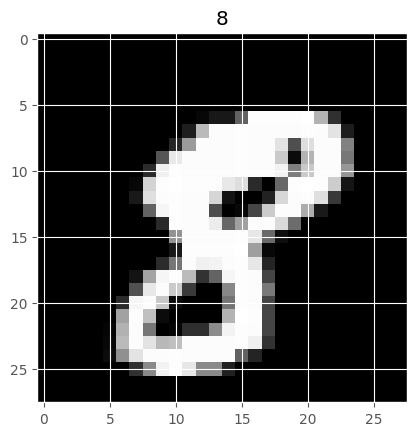

In [7]:
plt.imshow(X_train[10].reshape(28, 28), cmap="gray")
plt.title(y_train[10])
plt.show()

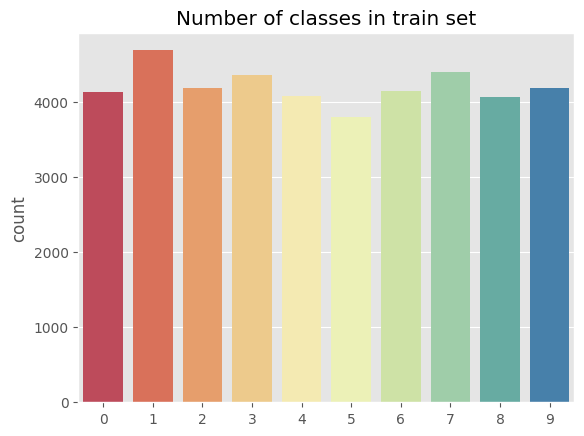

----------------------------------------
[4132 4684 4177 4351 4072 3795 4137 4401 4063 4188]


In [8]:
unique_values, counts = np.unique(y_train, return_counts=True)

plt.figure()
g = sns.countplot(x = y_train, palette="Spectral")
plt.title("Number of classes in train set")
plt.show()

print("-"*40)

print(counts)

# Preparation <a id=1.1></a>
# Normalization <a id=1.1.1></a>
For more details you can check my notebook about normalization [here](https://www.kaggle.com/code/atuzen/dive-into-normalization/) and [here](https://www.kaggle.com/code/atuzen/dive-into-normalization-2/) .

In [9]:
X_train = X_train / 255
X_test = X_test / 255

# Reshaping <a id=1.1.2></a>

In [10]:
X_train = X_train.reshape(-1, 28, 28)
X_test  = X_test.reshape(-1, 28, 28)

# Train - validation split <a id=1.1.3></a>

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((33600, 28, 28), (8400, 28, 28), (33600,), (8400,))

# Core architecture <a id=2></a>

Now, dataset is ready for us to work on.

***Please note that our purpose here is examining the regularization techniques, we are not here to hit perfect accuracies. Therefore our base architecture will be quite simple and number of epochs will be rather low.***

In [12]:
# Pytorch libraries

import torch
import torch.nn as nn

In [13]:
## This is our base architecture. we will make changes according to this architecture.

class CNN_no_reg(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        return h

In [14]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.FloatTensor(X_test)

In [15]:
base_model = CNN_no_reg()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-3)

**Lets train our core model and test the accuracy in validation set.**

In [16]:
num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    base_model.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    base_model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = base_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")

Epoch 1	Train Loss: 0.0031	Validation Loss: 0.0010	Validation Accuracy: 0.9636
Epoch 2	Train Loss: 0.0007	Validation Loss: 0.0007	Validation Accuracy: 0.9743
Epoch 3	Train Loss: 0.0005	Validation Loss: 0.0005	Validation Accuracy: 0.9798
Epoch 4	Train Loss: 0.0004	Validation Loss: 0.0004	Validation Accuracy: 0.9820
Epoch 5	Train Loss: 0.0003	Validation Loss: 0.0004	Validation Accuracy: 0.9827
Epoch 6	Train Loss: 0.0003	Validation Loss: 0.0004	Validation Accuracy: 0.9832
Epoch 7	Train Loss: 0.0002	Validation Loss: 0.0004	Validation Accuracy: 0.9824
Epoch 8	Train Loss: 0.0002	Validation Loss: 0.0005	Validation Accuracy: 0.9813
Epoch 9	Train Loss: 0.0002	Validation Loss: 0.0005	Validation Accuracy: 0.9801
Epoch 10	Train Loss: 0.0002	Validation Loss: 0.0005	Validation Accuracy: 0.9798
Epoch 11	Train Loss: 0.0001	Validation Loss: 0.0005	Validation Accuracy: 0.9807
Epoch 12	Train Loss: 0.0001	Validation Loss: 0.0005	Validation Accuracy: 0.9815
Epoch 13	Train Loss: 0.0001	Validation Loss: 0.00

**Lets create submission.csv file for base model.**

*Test accuracy for this core architecture -> 0.98542*

In [17]:
predictions = []

base_model.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = base_model(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_base.csv", index=False)

# Regularization techniques <a id=3></a>

Now, it is time to make some regularization to enchance our model's accuracy.

# Dropout <a id=3.1></a>

During training dropout randomly makes some neurons to inactive. This will prevent dependencies on individual neurons and we will have a more robust model. We can apply this operation to fc and conv layers.

### Architecture 1 <a id=3.1.1></a>

In [18]:
class CNN_dropout_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.dropout2 = nn.Dropout2d(0.25)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.dropout1(h)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.dropout2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        return h

In [19]:
model_drop_1 = CNN_dropout_conv()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_drop_1.parameters(), lr=1e-3)

In [20]:
num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    model_drop_1.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model_drop_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_drop_1.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_drop_1(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

    predictions = []

model_drop_1.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_drop_1(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_drop_1.csv", index=False)

# Final score 0.9885 on test set.

Epoch 1	Train Loss: 0.0037	Validation Loss: 0.0011	Validation Accuracy: 0.9577
Epoch 2	Train Loss: 0.0011	Validation Loss: 0.0007	Validation Accuracy: 0.9712
Epoch 3	Train Loss: 0.0008	Validation Loss: 0.0006	Validation Accuracy: 0.9775
Epoch 4	Train Loss: 0.0006	Validation Loss: 0.0005	Validation Accuracy: 0.9802
Epoch 5	Train Loss: 0.0006	Validation Loss: 0.0005	Validation Accuracy: 0.9804
Epoch 6	Train Loss: 0.0005	Validation Loss: 0.0005	Validation Accuracy: 0.9812
Epoch 7	Train Loss: 0.0005	Validation Loss: 0.0004	Validation Accuracy: 0.9849
Epoch 8	Train Loss: 0.0004	Validation Loss: 0.0004	Validation Accuracy: 0.9855
Epoch 9	Train Loss: 0.0004	Validation Loss: 0.0004	Validation Accuracy: 0.9845
Epoch 10	Train Loss: 0.0003	Validation Loss: 0.0003	Validation Accuracy: 0.9858
Epoch 11	Train Loss: 0.0003	Validation Loss: 0.0003	Validation Accuracy: 0.9865
Epoch 12	Train Loss: 0.0003	Validation Loss: 0.0003	Validation Accuracy: 0.9875
Epoch 13	Train Loss: 0.0003	Validation Loss: 0.00

### Architecture 2 <a id=3.1.2></a>

In [21]:
class CNN_dropout_fc(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        h = self.dropout(h)
        return h

In [22]:
model_drop_2 = CNN_dropout_fc()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_drop_2.parameters(), lr=1e-3)

num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    model_drop_2.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model_drop_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_drop_2.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_drop_2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

    predictions = []

model_drop_2.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_drop_2(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_drop_2.csv", index=False)

# Final score 0.98925 on test set.

Epoch 1	Train Loss: 0.0092	Validation Loss: 0.0014	Validation Accuracy: 0.9611
Epoch 2	Train Loss: 0.0074	Validation Loss: 0.0009	Validation Accuracy: 0.9679
Epoch 3	Train Loss: 0.0071	Validation Loss: 0.0008	Validation Accuracy: 0.9780
Epoch 4	Train Loss: 0.0070	Validation Loss: 0.0006	Validation Accuracy: 0.9806
Epoch 5	Train Loss: 0.0070	Validation Loss: 0.0005	Validation Accuracy: 0.9835
Epoch 6	Train Loss: 0.0069	Validation Loss: 0.0005	Validation Accuracy: 0.9815
Epoch 7	Train Loss: 0.0069	Validation Loss: 0.0004	Validation Accuracy: 0.9838
Epoch 8	Train Loss: 0.0068	Validation Loss: 0.0004	Validation Accuracy: 0.9864
Epoch 9	Train Loss: 0.0068	Validation Loss: 0.0003	Validation Accuracy: 0.9870
Epoch 10	Train Loss: 0.0067	Validation Loss: 0.0003	Validation Accuracy: 0.9877
Epoch 11	Train Loss: 0.0067	Validation Loss: 0.0003	Validation Accuracy: 0.9883
Epoch 12	Train Loss: 0.0068	Validation Loss: 0.0003	Validation Accuracy: 0.9875
Epoch 13	Train Loss: 0.0067	Validation Loss: 0.00

### Architecture 3 <a id=3.1.3></a>

In [23]:
class CNN_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.dropout2 = nn.Dropout2d(0.25)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.dropout1(h)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.dropout2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        h = self.dropout(h)
        return h

In [24]:
model_dropout = CNN_dropout()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=1e-3)

num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    model_dropout.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model_dropout(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_dropout.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_dropout(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

predictions = []

model_dropout.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_dropout(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_drop_3.csv", index=False)

# Final score 0.98846 on test set.

Epoch 1	Train Loss: 0.0097	Validation Loss: 0.0015	Validation Accuracy: 0.9583
Epoch 2	Train Loss: 0.0077	Validation Loss: 0.0009	Validation Accuracy: 0.9724
Epoch 3	Train Loss: 0.0075	Validation Loss: 0.0007	Validation Accuracy: 0.9755
Epoch 4	Train Loss: 0.0073	Validation Loss: 0.0006	Validation Accuracy: 0.9795
Epoch 5	Train Loss: 0.0072	Validation Loss: 0.0005	Validation Accuracy: 0.9810
Epoch 6	Train Loss: 0.0072	Validation Loss: 0.0005	Validation Accuracy: 0.9824
Epoch 7	Train Loss: 0.0070	Validation Loss: 0.0004	Validation Accuracy: 0.9846
Epoch 8	Train Loss: 0.0070	Validation Loss: 0.0004	Validation Accuracy: 0.9862
Epoch 9	Train Loss: 0.0070	Validation Loss: 0.0004	Validation Accuracy: 0.9852
Epoch 10	Train Loss: 0.0070	Validation Loss: 0.0004	Validation Accuracy: 0.9864
Epoch 11	Train Loss: 0.0069	Validation Loss: 0.0004	Validation Accuracy: 0.9880
Epoch 12	Train Loss: 0.0069	Validation Loss: 0.0004	Validation Accuracy: 0.9875
Epoch 13	Train Loss: 0.0069	Validation Loss: 0.00

### Results <a id=3.1.4></a>

In the first architecture, we add two dropout layers after the convolutional layers.

In the second architecture dropout layer added after fully connected layer.

The third architecture combines the first and second.

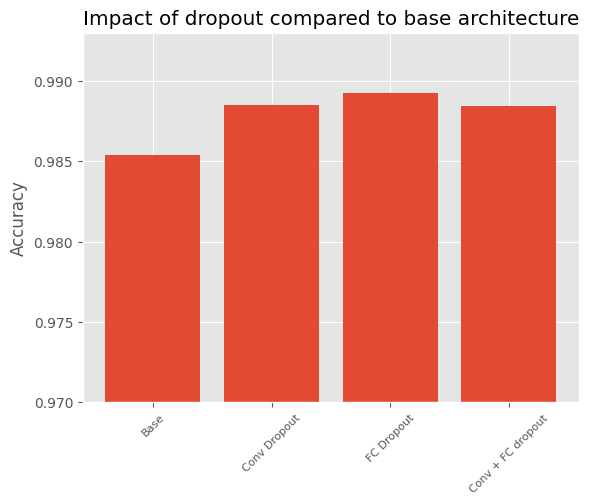

In [25]:
# I add the results manually here, I am pretty sure there are better ways to do this. But we have a lot to do still.

y_lims = [0.97, .993]
results = [0.98542, 0.9885, 0.98925, 0.98846]
labels = ["Base", "Conv Dropout", "FC Dropout", "Conv + FC dropout"]

plt.figure()
plt.title("Impact of dropout compared to base architecture")
plt.ylabel("Accuracy")
plt.xticks(fontsize = 8, rotation=45)
plt.bar(labels, results, label=labels)
ax = plt.gca()
ax.set_ylim(y_lims)
plt.show()

**In my experience, dropout shows differences when the number of epochs increases. If you use a low number of epochs, dropout may perform worse.**

**Note that dropout operation is based on randomness, therefore your results may differ from mine.**

**Overall, adding dropout regularization improves the performance on unseen data by a decent amount.**

# Batch normalization <a id=3.2></a>

### Architecture 1 <a id=3.2.1></a>

In [26]:
class CNN_batch_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.batch1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.batch1(h)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.batch2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        return h

In [27]:
model_batch_conv = CNN_batch_conv()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_batch_conv.parameters(), lr=1e-3)

num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    model_batch_conv.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model_batch_conv(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_batch_conv.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_batch_conv(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

predictions = []

model_batch_conv.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_batch_conv(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_batch_1.csv", index=False)

# Final score 0.98192 on test set.

Epoch 1	Train Loss: 0.0018	Validation Loss: 0.0007	Validation Accuracy: 0.9700
Epoch 2	Train Loss: 0.0005	Validation Loss: 0.0005	Validation Accuracy: 0.9787
Epoch 3	Train Loss: 0.0003	Validation Loss: 0.0005	Validation Accuracy: 0.9783
Epoch 4	Train Loss: 0.0002	Validation Loss: 0.0005	Validation Accuracy: 0.9776
Epoch 5	Train Loss: 0.0002	Validation Loss: 0.0005	Validation Accuracy: 0.9774
Epoch 6	Train Loss: 0.0002	Validation Loss: 0.0005	Validation Accuracy: 0.9781
Epoch 7	Train Loss: 0.0001	Validation Loss: 0.0005	Validation Accuracy: 0.9780
Epoch 8	Train Loss: 0.0001	Validation Loss: 0.0005	Validation Accuracy: 0.9799
Epoch 9	Train Loss: 0.0001	Validation Loss: 0.0005	Validation Accuracy: 0.9824
Epoch 10	Train Loss: 0.0001	Validation Loss: 0.0004	Validation Accuracy: 0.9861
Epoch 11	Train Loss: 0.0001	Validation Loss: 0.0004	Validation Accuracy: 0.9852
Epoch 12	Train Loss: 0.0000	Validation Loss: 0.0003	Validation Accuracy: 0.9876
Epoch 13	Train Loss: 0.0000	Validation Loss: 0.00

### Batch normalization + dropout <a id=3.2.2></a>

In [28]:
class CNN_batch_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.batch1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.batch1(h)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.batch2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        h = self.dropout(h)
        return h

In [29]:
model_batch_drop = CNN_batch_dropout()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_batch_drop.parameters(), lr=1e-3)

num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    model_batch_drop.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model_batch_drop(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_batch_drop.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_batch_drop(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

predictions = []

model_batch_drop.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_batch_drop(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_batch_2.csv", index=False)

# Final score 0.98192 on test set.

Epoch 1	Train Loss: 0.0082	Validation Loss: 0.0011	Validation Accuracy: 0.9680
Epoch 2	Train Loss: 0.0072	Validation Loss: 0.0007	Validation Accuracy: 0.9782
Epoch 3	Train Loss: 0.0070	Validation Loss: 0.0005	Validation Accuracy: 0.9830
Epoch 4	Train Loss: 0.0069	Validation Loss: 0.0005	Validation Accuracy: 0.9848
Epoch 5	Train Loss: 0.0069	Validation Loss: 0.0004	Validation Accuracy: 0.9857
Epoch 6	Train Loss: 0.0068	Validation Loss: 0.0004	Validation Accuracy: 0.9844
Epoch 7	Train Loss: 0.0068	Validation Loss: 0.0003	Validation Accuracy: 0.9871
Epoch 8	Train Loss: 0.0068	Validation Loss: 0.0003	Validation Accuracy: 0.9880
Epoch 9	Train Loss: 0.0068	Validation Loss: 0.0003	Validation Accuracy: 0.9870
Epoch 10	Train Loss: 0.0068	Validation Loss: 0.0003	Validation Accuracy: 0.9860
Epoch 11	Train Loss: 0.0067	Validation Loss: 0.0003	Validation Accuracy: 0.9877
Epoch 12	Train Loss: 0.0067	Validation Loss: 0.0003	Validation Accuracy: 0.9881
Epoch 13	Train Loss: 0.0067	Validation Loss: 0.00

# Layer normalization <a id=3.3></a>

Implementation of layer normalization is a bit different than others. We will add another fc layer first.

In [30]:
class CNN_layer_norm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 160)
        self.layernorm = nn.LayerNorm(160)
        self.relu3 = nn.ReLU() 
        self.fc2 = nn.Linear(160, 10)        
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        h = self.layernorm(h)
        h = self.relu3(h)
        h = self.fc2(h)
        return h

In [31]:
model_layernorm = CNN_layer_norm()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_layernorm.parameters(), lr=1e-3)

num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    model_layernorm.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model_layernorm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_layernorm.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_layernorm(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

predictions = []

model_layernorm.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_layernorm(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_layer.csv", index=False)

# Final score 0.99028 on test set.

Epoch 1	Train Loss: 0.0017	Validation Loss: 0.0005	Validation Accuracy: 0.9838
Epoch 2	Train Loss: 0.0004	Validation Loss: 0.0004	Validation Accuracy: 0.9863
Epoch 3	Train Loss: 0.0002	Validation Loss: 0.0004	Validation Accuracy: 0.9826
Epoch 4	Train Loss: 0.0001	Validation Loss: 0.0004	Validation Accuracy: 0.9845
Epoch 5	Train Loss: 0.0001	Validation Loss: 0.0003	Validation Accuracy: 0.9874
Epoch 6	Train Loss: 0.0001	Validation Loss: 0.0004	Validation Accuracy: 0.9869
Epoch 7	Train Loss: 0.0001	Validation Loss: 0.0004	Validation Accuracy: 0.9863
Epoch 8	Train Loss: 0.0001	Validation Loss: 0.0004	Validation Accuracy: 0.9836
Epoch 9	Train Loss: 0.0000	Validation Loss: 0.0005	Validation Accuracy: 0.9840
Epoch 10	Train Loss: 0.0000	Validation Loss: 0.0004	Validation Accuracy: 0.9871
Epoch 11	Train Loss: 0.0000	Validation Loss: 0.0004	Validation Accuracy: 0.9888
Epoch 12	Train Loss: 0.0000	Validation Loss: 0.0005	Validation Accuracy: 0.9845
Epoch 13	Train Loss: 0.0000	Validation Loss: 0.00

# Lasso, ridge and elastic regularization <a id=3.4></a>

These are fancy way to say L1, L2 and combination of L1 and L2 regularization. We will start with L2 as it is already implemented as a parameter in pytorch.

### L2 regularization <a id=3.4.1></a>

In [32]:
class CNN_l2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 160)
        self.relu3 = nn.ReLU() 
        self.fc2 = nn.Linear(160, 10)        
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        h = self.relu3(h)
        h = self.fc2(h)
        return h

In [33]:
model_l2 = CNN_l2()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_l2.parameters(), lr=1e-3, weight_decay = 1e-3)

num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    model_l2.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model_l2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_l2.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_l2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

predictions = []

model_l2.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_l2(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_l2.csv", index=False)

# Final score 0.98482 on test set.

Epoch 1	Train Loss: 0.0027	Validation Loss: 0.0009	Validation Accuracy: 0.9637
Epoch 2	Train Loss: 0.0007	Validation Loss: 0.0006	Validation Accuracy: 0.9760
Epoch 3	Train Loss: 0.0005	Validation Loss: 0.0005	Validation Accuracy: 0.9817
Epoch 4	Train Loss: 0.0004	Validation Loss: 0.0004	Validation Accuracy: 0.9848
Epoch 5	Train Loss: 0.0003	Validation Loss: 0.0004	Validation Accuracy: 0.9860
Epoch 6	Train Loss: 0.0003	Validation Loss: 0.0004	Validation Accuracy: 0.9858
Epoch 7	Train Loss: 0.0003	Validation Loss: 0.0003	Validation Accuracy: 0.9860
Epoch 8	Train Loss: 0.0002	Validation Loss: 0.0003	Validation Accuracy: 0.9857
Epoch 9	Train Loss: 0.0002	Validation Loss: 0.0003	Validation Accuracy: 0.9862
Epoch 10	Train Loss: 0.0002	Validation Loss: 0.0004	Validation Accuracy: 0.9849
Epoch 11	Train Loss: 0.0002	Validation Loss: 0.0003	Validation Accuracy: 0.9848
Epoch 12	Train Loss: 0.0002	Validation Loss: 0.0004	Validation Accuracy: 0.9851
Epoch 13	Train Loss: 0.0002	Validation Loss: 0.00

### L1 regularization <a id=3.4.2></a>

L1 regularization is not implemented in Adam optimizer, therefore we will do it ourselves.

In [34]:
class CNN_l1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 160)
        self.relu3 = nn.ReLU() 
        self.fc2 = nn.Linear(160, 10)        
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        h = self.relu3(h)
        h = self.fc2(h)
        return h

In [35]:
l1_lambda = 1e-4

model_l1 = CNN_l1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_l1.parameters(), lr=1e-3)

num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    model_l1.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model_l1(inputs)
        loss = criterion(outputs, labels)
        
        l1_reg = 0
        for param in model_l1.parameters():
            l1_reg += torch.abs(param).sum() 

        loss += l1_lambda * l1_reg        
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_l1.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_l1(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

predictions = []

model_l1.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_l1(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_l1.csv", index=False)

# Final score 0.97989 on test set.

Epoch 1	Train Loss: 0.0044	Validation Loss: 0.0011	Validation Accuracy: 0.9595
Epoch 2	Train Loss: 0.0020	Validation Loss: 0.0007	Validation Accuracy: 0.9730
Epoch 3	Train Loss: 0.0017	Validation Loss: 0.0006	Validation Accuracy: 0.9755
Epoch 4	Train Loss: 0.0015	Validation Loss: 0.0006	Validation Accuracy: 0.9739
Epoch 5	Train Loss: 0.0013	Validation Loss: 0.0006	Validation Accuracy: 0.9768
Epoch 6	Train Loss: 0.0012	Validation Loss: 0.0005	Validation Accuracy: 0.9799
Epoch 7	Train Loss: 0.0011	Validation Loss: 0.0004	Validation Accuracy: 0.9833
Epoch 8	Train Loss: 0.0010	Validation Loss: 0.0004	Validation Accuracy: 0.9848
Epoch 9	Train Loss: 0.0010	Validation Loss: 0.0004	Validation Accuracy: 0.9854
Epoch 10	Train Loss: 0.0009	Validation Loss: 0.0004	Validation Accuracy: 0.9856
Epoch 11	Train Loss: 0.0009	Validation Loss: 0.0004	Validation Accuracy: 0.9851
Epoch 12	Train Loss: 0.0009	Validation Loss: 0.0004	Validation Accuracy: 0.9855
Epoch 13	Train Loss: 0.0008	Validation Loss: 0.00

### Elastic net regularization<a id=3.4.3></a>

In [36]:
l1_lambda = 1e-4

model_l1 = CNN_l1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_l1.parameters(), lr=1e-3, weight_decay = 1e-3)

num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    model_l1.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model_l1(inputs)
        loss = criterion(outputs, labels)
        
        l1_reg = 0
        for param in model_l1.parameters():
            l1_reg += torch.abs(param).sum() 

        loss += l1_lambda * l1_reg        
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_l1.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_l1(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

predictions = []

model_l1.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_l1(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_elastic.csv", index=False)

# Final score 0.9825 on test set.

Epoch 1	Train Loss: 0.0043	Validation Loss: 0.0011	Validation Accuracy: 0.9587
Epoch 2	Train Loss: 0.0019	Validation Loss: 0.0009	Validation Accuracy: 0.9676
Epoch 3	Train Loss: 0.0016	Validation Loss: 0.0008	Validation Accuracy: 0.9687
Epoch 4	Train Loss: 0.0014	Validation Loss: 0.0008	Validation Accuracy: 0.9706
Epoch 5	Train Loss: 0.0013	Validation Loss: 0.0007	Validation Accuracy: 0.9708
Epoch 6	Train Loss: 0.0012	Validation Loss: 0.0007	Validation Accuracy: 0.9713
Epoch 7	Train Loss: 0.0011	Validation Loss: 0.0007	Validation Accuracy: 0.9730
Epoch 8	Train Loss: 0.0010	Validation Loss: 0.0007	Validation Accuracy: 0.9740
Epoch 9	Train Loss: 0.0010	Validation Loss: 0.0005	Validation Accuracy: 0.9790
Epoch 10	Train Loss: 0.0010	Validation Loss: 0.0005	Validation Accuracy: 0.9806
Epoch 11	Train Loss: 0.0009	Validation Loss: 0.0005	Validation Accuracy: 0.9826
Epoch 12	Train Loss: 0.0009	Validation Loss: 0.0005	Validation Accuracy: 0.9827
Epoch 13	Train Loss: 0.0008	Validation Loss: 0.00

# Data augmentation <a id=3.5></a>

Data augmentation is a well-known and highly effective regularization technique.

In this notebook, we will keep it as simple as we can, just using rotation, horizontal flip (no vertical flip for this dataset). You are welcome to try other methods as well.

In [37]:
from torchvision.transforms import v2

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [38]:
transforms = v2.Compose([
    v2.RandomRotation(degrees = 20), # Randomly rotates the image in range of (-20, 20) 
    v2.RandomHorizontalFlip(p = 0.3), # Randomly flips the image horizontally
    v2.ToDtype(torch.float32),
])

X_train_aug = transforms(X_train)

In [39]:
class CNN_aug(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 160)
        self.relu3 = nn.ReLU() 
        self.fc2 = nn.Linear(160, 10)        
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        h = self.relu3(h)
        h = self.fc2(h)
        return h

In [40]:
model_aug = CNN_aug()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_aug.parameters(), lr=1e-3)

num_epochs = 25
batch_size = 128

for epoch in range(num_epochs):
    model_aug.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs_orig = X_train[i:i+batch_size].unsqueeze(1)
        inputs_aug = X_train_aug[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs_orig = model_aug(inputs_orig)        
        outputs_aug = model_aug(inputs_aug)
        loss = criterion(outputs_orig, labels) + criterion(outputs_aug, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_aug.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_aug(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

predictions = []

model_aug.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_aug(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_aug.csv", index=False)

# Final score 0.97932 on test set, this technique requires a little bit more training.

Epoch 1	Train Loss: 0.0055	Validation Loss: 0.0009	Validation Accuracy: 0.9649
Epoch 2	Train Loss: 0.0014	Validation Loss: 0.0006	Validation Accuracy: 0.9743
Epoch 3	Train Loss: 0.0009	Validation Loss: 0.0005	Validation Accuracy: 0.9787
Epoch 4	Train Loss: 0.0007	Validation Loss: 0.0004	Validation Accuracy: 0.9833
Epoch 5	Train Loss: 0.0006	Validation Loss: 0.0004	Validation Accuracy: 0.9854
Epoch 6	Train Loss: 0.0005	Validation Loss: 0.0004	Validation Accuracy: 0.9861
Epoch 7	Train Loss: 0.0004	Validation Loss: 0.0004	Validation Accuracy: 0.9857
Epoch 8	Train Loss: 0.0003	Validation Loss: 0.0004	Validation Accuracy: 0.9845
Epoch 9	Train Loss: 0.0003	Validation Loss: 0.0004	Validation Accuracy: 0.9844
Epoch 10	Train Loss: 0.0002	Validation Loss: 0.0006	Validation Accuracy: 0.9794
Epoch 11	Train Loss: 0.0002	Validation Loss: 0.0005	Validation Accuracy: 0.9820
Epoch 12	Train Loss: 0.0002	Validation Loss: 0.0005	Validation Accuracy: 0.9827
Epoch 13	Train Loss: 0.0002	Validation Loss: 0.00

# Final architecture <a id=4></a>

We examined a lot of regularization techniques all of them increased our accuracy on test set (some required longer trains), some of them in small amount while others enchanced base architecture quite well.

Are we gonna use all of them in the final architecture? No.

Some techniques are better suited for CNN architecture, such as batch normalization is widely used for CNNs and layer normalization is proposed for RNN type of deep models.

Also, we will skip L1, L2 and elastic regularizations in the final implementation. I am afraid to say this, they are certainly strong methods, but kind of outdated :(.

We will also tune the data augmentation a little bit down. And increase number of epochs to 40.

In [41]:
transforms = v2.Compose([
    v2.RandomRotation(degrees = 15), # Randomly rotates the image in range of (-15, 15) 
    v2.RandomHorizontalFlip(p = 0.25), # Randomly flips the image horizontally
    v2.ToDtype(torch.float32),
])

X_train_aug = transforms(X_train)

In [42]:
class CNN_final(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=1)
        self.batch1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout2d(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout2d(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 32 * 5)
        self.dropout3 = nn.Dropout(0.25)
        self.relu3 = nn.ReLU() 
        self.fc2 = nn.Linear(32 * 5, 10)        
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.batch1(h)
        h = self.relu1(h)
        h = self.dropout1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.batch2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = self.dropout2(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h)
        h = self.dropout3(h)
        h = self.relu3(h)
        h = self.fc2(h)
        return h

In [43]:
model_final = CNN_final()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_final.parameters(), lr=1e-3)

num_epochs = 40
batch_size = 128

for epoch in range(num_epochs):
    model_final.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs_orig = X_train[i:i+batch_size].unsqueeze(1)
        inputs_aug = X_train_aug[i:i+batch_size].unsqueeze(1)
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs_orig = model_final(inputs_orig)        
        outputs_aug = model_final(inputs_aug)
        loss = criterion(outputs_orig, labels) + criterion(outputs_aug, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model_final.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1)
            labels = y_val[i:i+batch_size]
            outputs = model_final(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}\tTrain Loss: {(train_loss/len(X_train)):.4f}\tValidation Loss: {(val_loss/len(X_val)):.4f}\tValidation Accuracy: {(val_correct/val_total):.4f}")
    

predictions = []

model_final.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1)
        outputs = model_final(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})

submission_df.to_csv("submission_final.csv", index=False)

Epoch 1	Train Loss: 0.0040	Validation Loss: 0.0006	Validation Accuracy: 0.9758
Epoch 2	Train Loss: 0.0012	Validation Loss: 0.0004	Validation Accuracy: 0.9836
Epoch 3	Train Loss: 0.0009	Validation Loss: 0.0003	Validation Accuracy: 0.9873
Epoch 4	Train Loss: 0.0007	Validation Loss: 0.0003	Validation Accuracy: 0.9873
Epoch 5	Train Loss: 0.0006	Validation Loss: 0.0003	Validation Accuracy: 0.9882
Epoch 6	Train Loss: 0.0005	Validation Loss: 0.0003	Validation Accuracy: 0.9907
Epoch 7	Train Loss: 0.0004	Validation Loss: 0.0003	Validation Accuracy: 0.9880
Epoch 8	Train Loss: 0.0004	Validation Loss: 0.0003	Validation Accuracy: 0.9887
Epoch 9	Train Loss: 0.0003	Validation Loss: 0.0003	Validation Accuracy: 0.9894
Epoch 10	Train Loss: 0.0003	Validation Loss: 0.0003	Validation Accuracy: 0.9898
Epoch 11	Train Loss: 0.0003	Validation Loss: 0.0002	Validation Accuracy: 0.9919
Epoch 12	Train Loss: 0.0002	Validation Loss: 0.0003	Validation Accuracy: 0.9889
Epoch 13	Train Loss: 0.0003	Validation Loss: 0.00

## Final submission score: 0.99114

##### I appreciate any feedback. Please let me know if anything is missing or if you would like to add anything. I hope you enjoy this notebook.

##### Links: [GitHub](https://github.com/ahmetTuzen/) and [LinkedIn](https://www.linkedin.com/in/ahmet-tuzen/)